In [38]:
import numpy as np 
import tensorflow as tf
import pdb
import math 
import matplotlib.pyplot as plt

In [2]:
def real2bits(value,bits=8,radius=1.5):
    binary = np.zeros([bits,])
    step = radius/(2**bits/2)
    if value < 0:
        binary[0] = 1
    integer = int(np.floor(np.abs(value/step)))
    done = False 
    i = bits-1
    while not done: 
        binary[i] = integer % 2
        integer = int(integer/2)
        if integer == 0:
            done = True 
        else:
            i -= 1 
    return binary

In [3]:
def bits2real(bit_array,bits=8,radius=1.5):
    step = radius/(2**(bits-1))
    weights = np.zeros([bits,])
#     weights[0] = -1.0
    for i in range(bits-1):
        weights[bits-i-1] = 2**i
    value = weights.dot(bit_array)*step
    if bool(bit_array[0]):
        value *= -1.0
    return value

In [4]:
def tf_bits2real(X, bits=8,radius=1.5): #FIXME 
    step = radius/(2**(bits-1))
    weight_list = [0]
    for i in range(bits-1):
        power = bits - 2 - i 
        weight_list.append(2**power*step)
    weight_list = np.array(weight_list)
    weight_list = weight_list.reshape([-1,1])
#     pdb.set_trace()
    conversion_tensor = tf.constant(weight_list,
                                   dtype=tf.float32)
#     pdb.set_trace()
    real_output = tf.matmul(X, conversion_tensor,
                            transpose_a=False)
    idx_array = np.zeros([bits,1])
    idx_array[0] = 1
    idx_tensor = tf.constant(idx_array,
                            dtype=tf.float32)
    neg = tf.matmul(X,idx_tensor)
    neg_factor = tf.multiply(neg, tf.constant(-2, dtype=tf.float32))
    scale = neg_factor + 1.0
    real_output = tf.multiply(real_output, scale)
#     tf.cond(tf.cast(neg,tf.bool), )
    return real_output

In [5]:
def pseudo_huber(t, delta):
    L = delta**2*(tf.sqrt(1 + (t/delta)**2)-1)
    return L 

In [74]:
def multi_linear_loss(t, alpha, beta, gamma, zeta):
    loss_pos = tf.nn.relu(alpha*t) - tf.nn.relu(alpha*(t-gamma)) + tf.nn.relu(beta*(t-gamma))
    loss_neg = tf.nn.relu(-alpha*t) - tf.nn.relu(-alpha*(t+gamma)) +  tf.nn.relu(-beta*(t+gamma))
#     loss_neg = 0
    loss = loss_pos + loss_neg 
    loss = tf.reduce_sum(loss, axis=1)
    return loss 

In [8]:
def basic_MLP(X,y,sizes,is_training,bits=8,dropout=False): 
    layers = {}
    layers[0] = tf.layers.dense(X, sizes[0],
                                activation = tf.nn.relu,
                                use_bias=False,
                                )
    if dropout:
        dropout_key = str(0)+'d' 
        layers[dropout_key] = tf.layers.dropout(layers[0],
                                                rate=0.25,
                                                training=is_training)
    for j,  size in enumerate(sizes[1:]): 
        i = j+1
        if dropout: 
            dropout_key_prior = str(i-1)+'d' 
            layers[i] = tf.layers.dense(layers[dropout_key_prior], size,
                                    activation = tf.nn.relu,
                                    use_bias=False,
                                    )
            dropout_key = str(i)+'d' 
            layers[dropout_key] = tf.layers.dropout(layers[dropout_key],
                                                rate=0.25,
                                                training=is_training)
        else:
            layers[i] = tf.layers.dense(layers[i-1], size,
                                    activation = tf.nn.relu,
                                    use_bias=False,
                                    )

    output = tf.layers.dense(layers[len(sizes)-1], bits,
                                   activation = None,
                                   use_bias=False,
                                    ) #used relu to guarentee no negative values
    return output


In [79]:
def bit_loss(X,y,bits=8):
    diff = tf.subtract(X, y)
#     loss = tf.nn.l2_loss(diff)
#     loss = pseudo_huber(diff, 0.1)
    loss = multi_linear_loss(diff, alpha=0.1, beta=10, gamma=0.2, zeta=5)
    return loss 

In [80]:
def weighted_bit_loss(X,y,bits=8,radius=1.5):
    step = radius/(2**(bits-1))
    weight_list = [radius]
    for i in range(bits-1):
        power = bits - 2 - i 
#         weight_list.append(2**power*step)
        weight_list.append(power*step)
    weight_list = np.array(weight_list)
    weight_list = weight_list.reshape([1,-1])
    conversion_tensor = tf.constant(weight_list,
                                   dtype=tf.float32)
    diff = tf.subtract(X, y)
    weighted_diff = tf.multiply(diff, conversion_tensor)
    print(weighted_diff.shape)
#     loss = tf.nn.l2_loss(weighted_diff)
#     loss = pseudo_huber(weighted_diff, 0.1)
    loss = multi_linear_loss(weighted_diff, alpha=0.1, beta=10, gamma=0.2, zeta=5)
    print(loss.shape)    
    return loss 

In [14]:
def reg_loss(w_list):
#     w_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    loss = 0.0
    for w in w_list: 
        loss += tf.nn.l2_loss(w)
    return loss

In [15]:
# def get_weights():
#   return [v for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES) if v.name.endswith('weights:0')]

In [81]:
SIZES = [128, 256, 512]
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=[None,1],name='Input')
y = tf.placeholder(tf.float32, shape=[None,4],name='Correct_output')
is_training = tf.placeholder(tf.bool,name='training')
output = basic_MLP(X,y,SIZES,is_training,bits=4,dropout=False)
# real_output = tf_bits2real(output,bits=16)
# p_loss = weighted_bit_loss(output,y,bits=4,radius=1.5)
p_loss = bit_loss(output,y)
w_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
r_loss = reg_loss(w_list)
mean_loss = tf.reduce_mean(p_loss +  0.00*r_loss)
optimizer = tf.train.AdamOptimizer(1e-6) 
train_step = optimizer.minimize(mean_loss)

In [82]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

xd = np.arange(0, 1.49, 0.01)
# xd = np.ones([1000,1])
# np.random.shuffle(xd)
yd = np.zeros([xd.shape[0],4])
for i, x in enumerate(xd):
    yd[i,:] = real2bits(x, bits=4, radius=1.5)
#     yd[i] = bits2real(yd_, bits=16, radius=1.5)
xd = xd.reshape([-1,1])

In [83]:
for i in range(10000):
#     idx = np.random.randint(0,xd.shape[0]-1,100)
#     ml, _ = sess.run([mean_loss, train_step],feed_dict={X: xd[idx,:], y: yd[idx]})
    ml, _ = sess.run([mean_loss, train_step],feed_dict={X: xd, y: yd})
    if i % 1000 == 0:
        print(ml)

# total_loss, total_correct = run_model(sess, real_output, loss, xd, yd,
#                                       epochs=1, batch_size=64, print_every=100,
#                                       training=train_step, plot_losses=True)

# iter_cnt,loss,np.sum(corr)/actual_batch_size

11.4773
10.1287
8.7737
7.6923
6.81121
6.2502
5.81001
5.72803
5.72684
5.72675


In [84]:
correct = tf.equal(tf.round(output), y)
accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))
print(sess.run([accuracy],feed_dict={X: xd, y: yd}))

[0.75838923]


In [85]:
print(sess.run([tf.round(output)],feed_dict={X: xd, y: yd})[0][100:150,:])

[[ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]]


In [86]:
print(yd[100:150])

[[ 0.  1.  0.  1.]
 [ 0.  1.  0.  1.]
 [ 0.  1.  0.  1.]
 [ 0.  1.  0.  1.]
 [ 0.  1.  0.  1.]
 [ 0.  1.  0.  1.]
 [ 0.  1.  0.  1.]
 [ 0.  1.  0.  1.]
 [ 0.  1.  0.  1.]
 [ 0.  1.  0.  1.]
 [ 0.  1.  0.  1.]
 [ 0.  1.  0.  1.]
 [ 0.  1.  0.  1.]
 [ 0.  1.  1.  0.]
 [ 0.  1.  1.  0.]
 [ 0.  1.  1.  0.]
 [ 0.  1.  1.  0.]
 [ 0.  1.  1.  0.]
 [ 0.  1.  1.  0.]
 [ 0.  1.  1.  0.]
 [ 0.  1.  1.  0.]
 [ 0.  1.  1.  0.]
 [ 0.  1.  1.  0.]
 [ 0.  1.  1.  0.]
 [ 0.  1.  1.  0.]
 [ 0.  1.  1.  0.]
 [ 0.  1.  1.  0.]
 [ 0.  1.  1.  0.]
 [ 0.  1.  1.  0.]
 [ 0.  1.  1.  0.]
 [ 0.  1.  1.  0.]
 [ 0.  1.  1.  0.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]]


In [75]:
tf.reset_default_graph()
sess = tf.Session()
t = tf.placeholder(tf.float32, shape=[None,1])
loss = multi_linear_loss(t, alpha=0.1, beta=1.0, gamma=0.4, zeta=5)

In [76]:
t_test = np.arange(-1,1,0.1).reshape([-1,1])
loss_test = sess.run(loss, feed_dict={t:t_test})

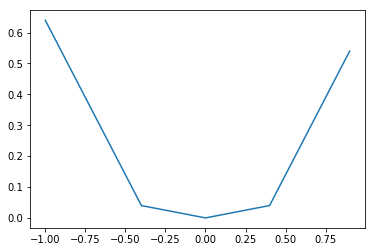

In [77]:
plt.figure()
plt.plot(t_test, loss_test)
plt.show()